# NFL Field Goal Miss Prediction Analysis

## Problem Statement

**Objective**: Build a machine learning model to predict whether an NFL field goal attempt will be **MISSED** (positive class) based on game context, field position, environmental conditions, and situational factors.

**Motivation**: Field goal success is critical in NFL games, often determining game outcomes. Understanding the factors that contribute to missed field goals can provide valuable insights for:
- **Coaching decisions**: When to attempt vs. punt on 4th down
- **Game strategy**: Risk assessment in different game situations  
- **Player evaluation**: Kicker performance under various conditions
- **Sports analytics**: Advanced metrics for field goal difficulty

**Data Source**: This analysis uses NFL play-by-play data from Pro Football Focus (PFF) covering the 2016-2021 seasons. *Note: This dataset is proprietary and not publicly available.*

**Technical Challenges**:
- **Class imbalance**: Field goals are made ~79% of the time (minority class prediction)
- **Missing data**: Weather and environmental data has significant gaps
- **Feature engineering**: Converting raw play data into meaningful predictors
- **Collinearity**: Many weather and situational variables are highly correlated

**Approach**: This notebook implements a complete machine learning pipeline including data cleaning, exploratory analysis, feature selection, model training with hyperparameter tuning, and comprehensive evaluation focused on minority class detection.

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading & Initial Filtering

In [2]:
# Load the full CSV
df = pd.read_csv('punts_fieldgoals_2016-2021.csv')

# Keep only FIELD GOAL attempts (remove punts and extra points)
df = df[df['special_teams_type'] == 'FIELD GOAL'].copy()

# Remove punt-related columns that don't apply to field goals
punt_columns = ['net_punt_yards', 'hang_time']
df = df.drop(columns=punt_columns, errors='ignore')  # errors='ignore' in case columns don't exist

print(f"Total rows after filtering to field goals: {len(df)}")
print(f"Removed punt-related columns: {punt_columns}")
df.head()

Total rows after filtering to field goals: 27810
Removed punt-related columns: ['net_punt_yards', 'hang_time']


,season,league,week,game_id,play_id,quarter,clock,absoluteyardline,absoluteyardline_np,offense_team,...,humidity,ozone,precip_intensity,precip_probability,pressure,uv_index,visibility,wind_bearing,wind_gust,wind_speed
1,2016,NFL,09,4220,1193666,2,01:19,22,47.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
9,2016,NFL,09,4220,1193062,1,05:55,16,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
14,2016,NFL,09,4220,1194265,4,12:06,8,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
17,2016,NFL,09,4220,1194485,4,03:55,21,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
26,2020,NCAA,12,18022,3702550,1,07:32,20,65.0,MSSO,...,59.00,NaN,NaN,26.0,1025.00,5.0,6.000,81.0,5.00,4.00


## 3. Exploratory Data Analysis

In [3]:
# Basic info
display(df.head())
print(df.info())
print(df.describe())

,season,league,week,game_id,play_id,quarter,clock,absoluteyardline,absoluteyardline_np,offense_team,...,humidity,ozone,precip_intensity,precip_probability,pressure,uv_index,visibility,wind_bearing,wind_gust,wind_speed
1,2016,NFL,09,4220,1193666,2,01:19,22,47.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
9,2016,NFL,09,4220,1193062,1,05:55,16,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
14,2016,NFL,09,4220,1194265,4,12:06,8,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
17,2016,NFL,09,4220,1194485,4,03:55,21,65.0,PHI,...,0.42,NaN,0.0,0.0,1022.36,2.0,9.997,344.0,12.43,5.88
26,2020,NCAA,12,18022,3702550,1,07:32,20,65.0,MSSO,...,59.00,NaN,NaN,26.0,1025.00,5.0,6.000,81.0,5.00,4.00


<class 'pandas.core.frame.DataFrame'>
Index: 27810 entries, 1 to 167207
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                27810 non-null  int64  
 1   league                27810 non-null  object 
 2   week                  27810 non-null  object 
 3   game_id               27810 non-null  int64  
 4   play_id               27810 non-null  int64  
 5   quarter               27810 non-null  int64  
 6   clock                 27810 non-null  object 
 7   absoluteyardline      27810 non-null  int64  
 8   absoluteyardline_np   27466 non-null  float64
 9   offense_team          27810 non-null  object 
 10  defense_team          27810 non-null  object 
 11  kicker_id             27808 non-null  float64
 12  special_teams_type    27810 non-null  object 
 13  kick_result           27810 non-null  object 
 14  play_points_scored    20933 non-null  float64
 15  fg_distance           2

In [4]:
# Missing values per column
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(10)

elevation             24748
ozone                 19930
precip_intensity       8564
play_points_scored     6877
pressure               4265
wind_bearing           3871
wind_gust              3786
cloud_cover            3785
uv_index               3785
visibility             3779
dtype: int64

In [5]:
# Kick result distribution
print(df['kick_result'].value_counts())

kick_result
MADE - M       14383
MADE - IR       3389
MADE - IL       3263
MISSED - WR     2439
MISSED - WL     2420
BLOCKED          881
MISSED - S       428
MISSED - HR      295
MISSED - HL      263
MISSED - HC       42
MISSED - B         4
FAKE               2
MISSED             1
Name: count, dtype: int64


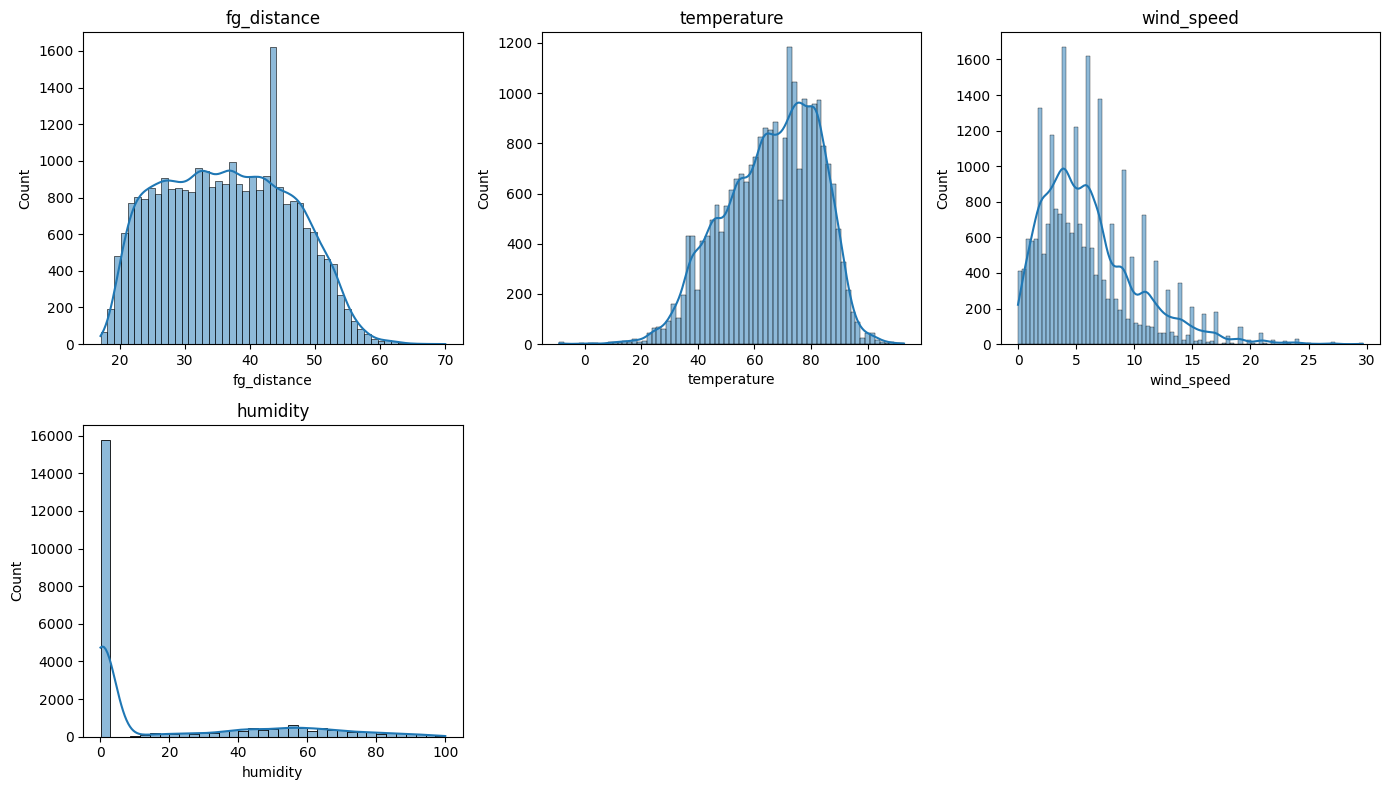

In [6]:
# Numeric distributions
num_cols = ['fg_distance','temperature','wind_speed','humidity']
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    if col in df.columns:
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(col)
plt.tight_layout(); plt.show()

=== MISS RATES BY NUMERICAL VARIABLES (BINNED) ===


TEMPERATURE:
----------------------------------------
                    Total_Attempts  Misses  Miss_Rate
temperature_binned                                   
50°F+                        19283    4030      0.209
20-30°F                        318      64      0.201
30-40°F                       1443     286      0.198
40-50°F                       2779     510      0.184
10-20°F                         67       7      0.104
<0°F                            11       1      0.091
0-10°F                          22       1      0.045


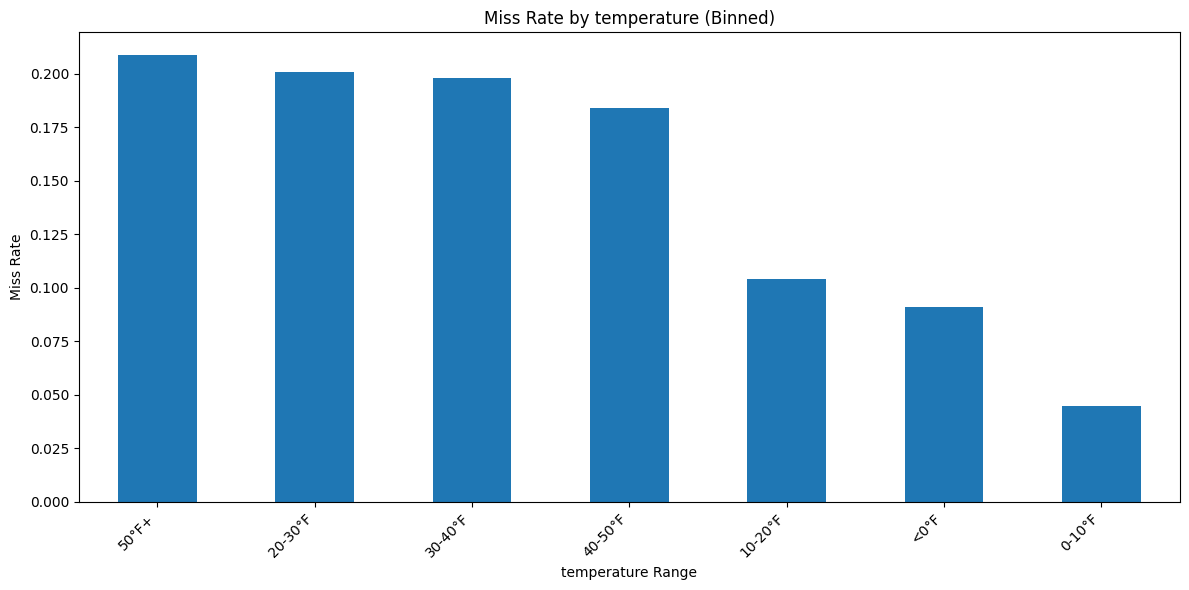


FG_DISTANCE:
----------------------------------------
                    Total_Attempts  Misses  Miss_Rate
fg_distance_binned                                   
60+                             58      34      0.586
55-60                          309     164      0.531
50-55                         1844     804      0.436
45-50                         3559    1313      0.369
40-45                         4241    1236      0.291
35-40                         4493     976      0.217
30-35                         4480     719      0.160
25-30                         4259     401      0.094
20-25                         3828     220      0.057
<20                            739      25      0.034


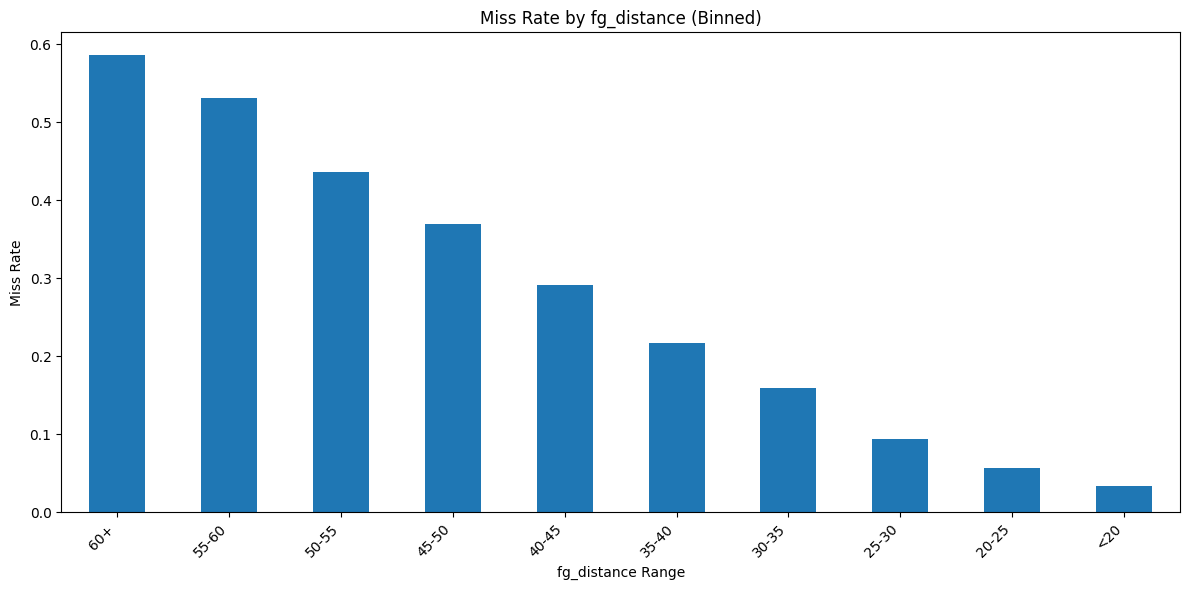


WIND_SPEED:
----------------------------------------
                   Total_Attempts  Misses  Miss_Rate
wind_speed_binned                                   
25-30 mph                      22       6      0.273
20-25 mph                     156      34      0.218
15-20 mph                     642     134      0.209
0-5 mph                     11615    2409      0.207
10-15 mph                    2759     569      0.206
5-10 mph                     8840    1779      0.201
30+ mph                         0       0        NaN


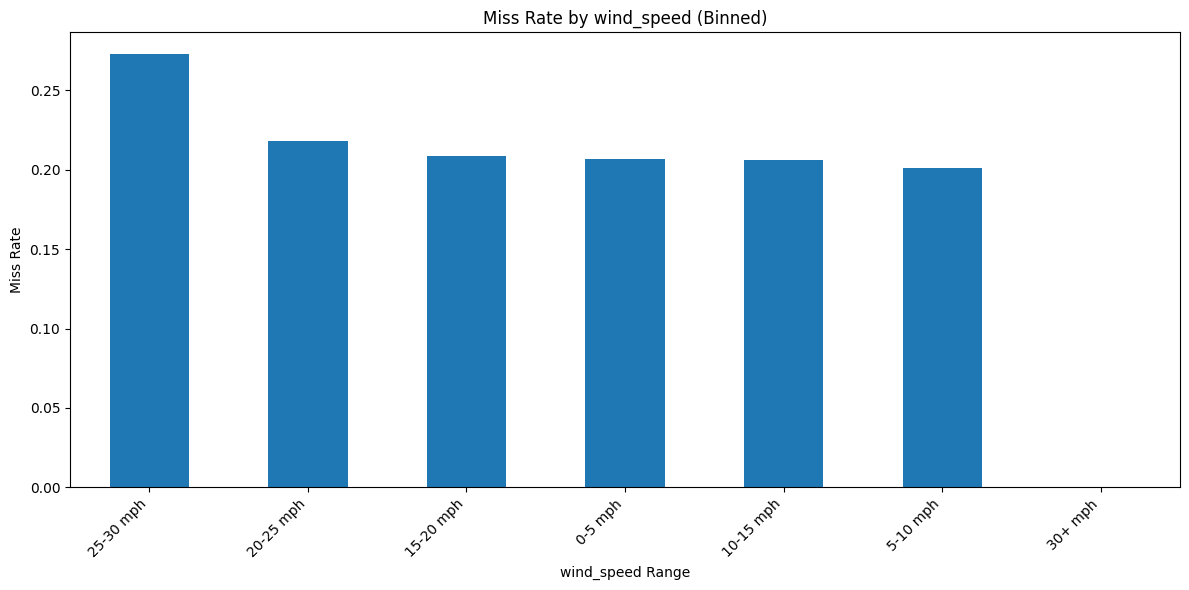


HUMIDITY:
----------------------------------------
                 Total_Attempts  Misses  Miss_Rate
humidity_binned                                   
50-60%                     1686     383      0.227
70-80%                      860     191      0.222
80-90%                      582     126      0.216
0-20%                     16221    3330      0.205
30-40%                      928     185      0.199
60-70%                     1413     274      0.194
40-50%                     1407     272      0.193
90-100%                     325      62      0.191
20-30%                      612     108      0.176


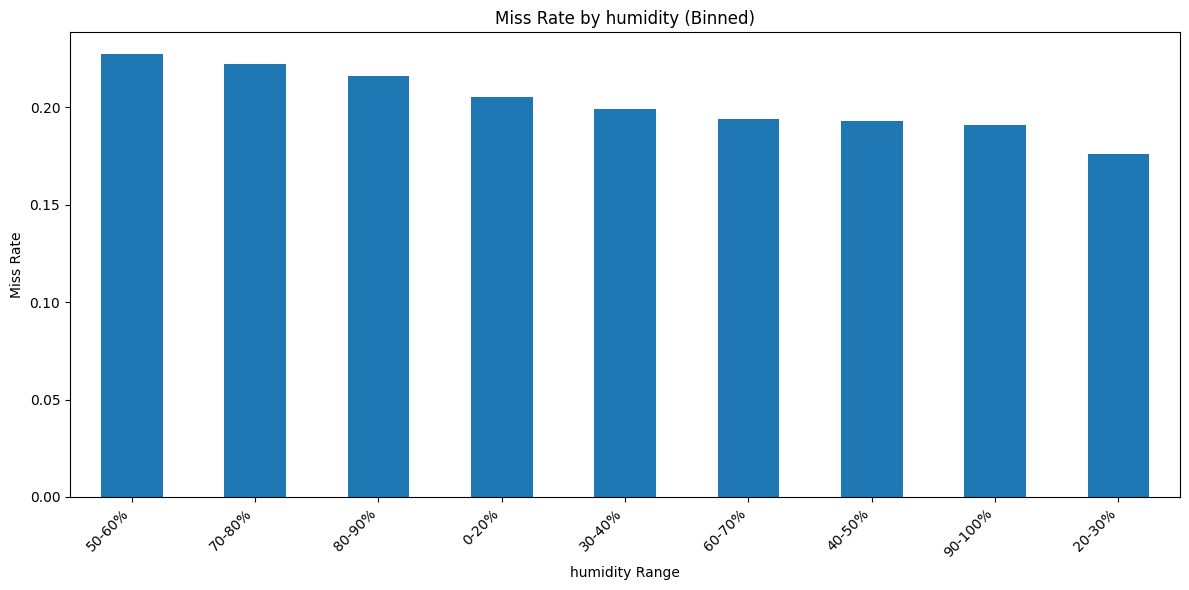

In [7]:
# Create binary target for missed kicks
df['missed'] = df['kick_result'].str.contains('MISSED', na=False).astype(int)

# Define numerical variables to analyze
numerical_vars = ['temperature', 'fg_distance', 'wind_speed', 'humidity']

print("=== MISS RATES BY NUMERICAL VARIABLES (BINNED) ===\n")

for var in numerical_vars:
    if var in df.columns:
        print(f"\n{var.upper()}:")
        print("-" * 40)
        
        # Create bins for the numerical variable
        if var == 'fg_distance':
            # Create distance bins (every 5 yards)
            bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
            labels = ['<20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60+']
        elif var == 'temperature':
            # Create temperature bins (every 10 degrees)
            bins = [-50, 0, 10, 20, 30, 40, 50, 100]
            labels = ['<0°F', '0-10°F', '10-20°F', '20-30°F', '30-40°F', '40-50°F', '50°F+']
        elif var == 'wind_speed':
            # Create wind speed bins
            bins = [0, 5, 10, 15, 20, 25, 30, 100]
            labels = ['0-5 mph', '5-10 mph', '10-15 mph', '15-20 mph', '20-25 mph', '25-30 mph', '30+ mph']
        elif var == 'humidity':
            # Create humidity bins (every 10%)
            bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            labels = ['0-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
        else:
            # Default bins
            bins = 10
            labels = None
        
        # Create binned column
        df[f'{var}_binned'] = pd.cut(df[var], bins=bins, labels=labels, include_lowest=True)
        
        # Calculate miss rates by bin
        miss_rates = df.groupby(f'{var}_binned')['missed'].agg(['count', 'sum', 'mean']).round(3)
        miss_rates.columns = ['Total_Attempts', 'Misses', 'Miss_Rate']
        miss_rates = miss_rates.sort_values('Miss_Rate', ascending=False)
        
        # Display results
        print(miss_rates)
        
        # Create a bar plot
        plt.figure(figsize=(12, 6))
        miss_rates['Miss_Rate'].plot(kind='bar')
        plt.title(f'Miss Rate by {var} (Binned)')
        plt.ylabel('Miss Rate')
        plt.xlabel(f'{var} Range')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Clean up
        df = df.drop(columns=[f'{var}_binned'])

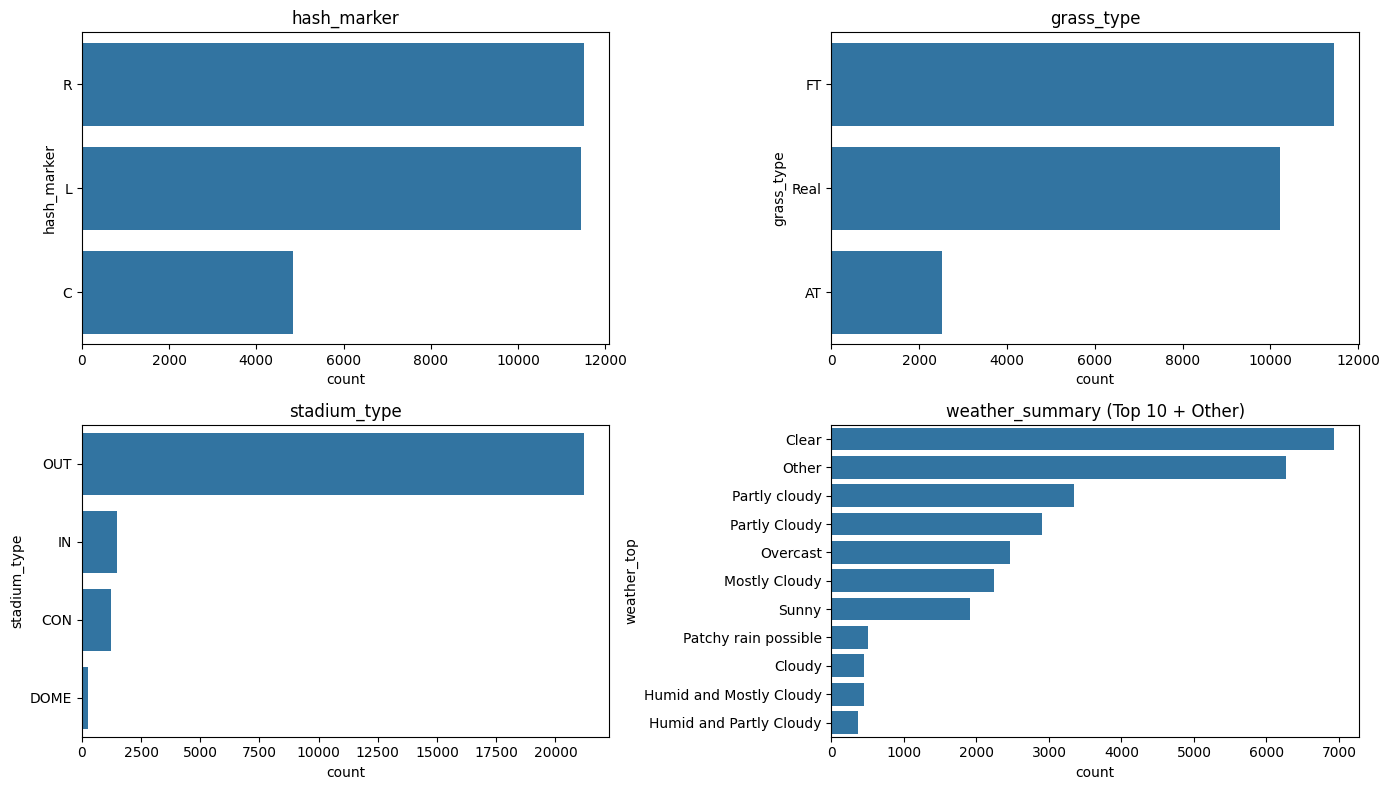

In [8]:
# Categorical feature distributions (with top-10 cap for weather_summary)
plt.figure(figsize=(14, 8))

# 1–3: hash_marker, grass_type, stadium_type
for i, col in enumerate(['hash_marker', 'grass_type', 'stadium_type'], start=1):
    plt.subplot(2, 2, i)
    if col in df.columns:
        sns.countplot(
            y=df[col],
            order=df[col].value_counts().index
        )
        plt.title(col)

# 4: weather_summary (top 10 + "Other")
if 'weather_summary' in df.columns:
    # Determine top 10 weather categories
    top_n = 10
    top_cats = df['weather_summary']\
        .value_counts()\
        .nlargest(top_n)\
        .index
    # Collapse rest into 'Other'
    df['weather_top'] = df['weather_summary']\
        .where(df['weather_summary'].isin(top_cats), 'Other')
    plt.subplot(2, 2, 4)
    sns.countplot(
        y=df['weather_top'],
        order=df['weather_top'].value_counts().index
    )
    plt.title('weather_summary (Top 10 + Other)')

plt.tight_layout()
plt.show()


=== MISS RATES BY CATEGORICAL VARIABLES ===


HASH_MARKER:
----------------------------------------
             Total_Attempts  Misses  Miss_Rate
hash_marker                                   
R                     11512    2469      0.214
L                     11450    2437      0.213
C                      4848     986      0.203


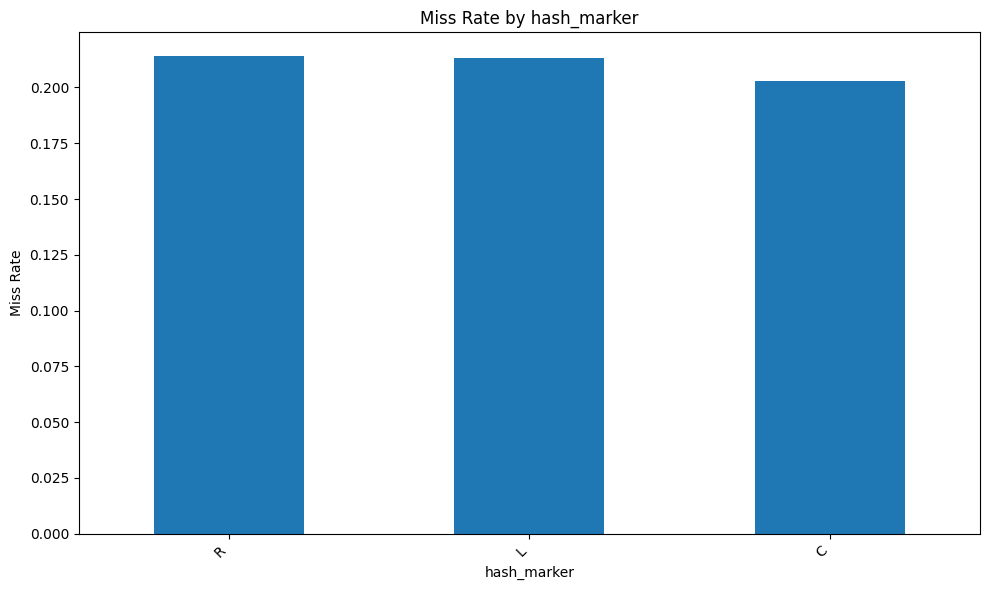


GRASS_TYPE:
----------------------------------------
            Total_Attempts  Misses  Miss_Rate
grass_type                                   
FT                   11445    2530      0.221
Real                 10220    1990      0.195
AT                    2529     454      0.180


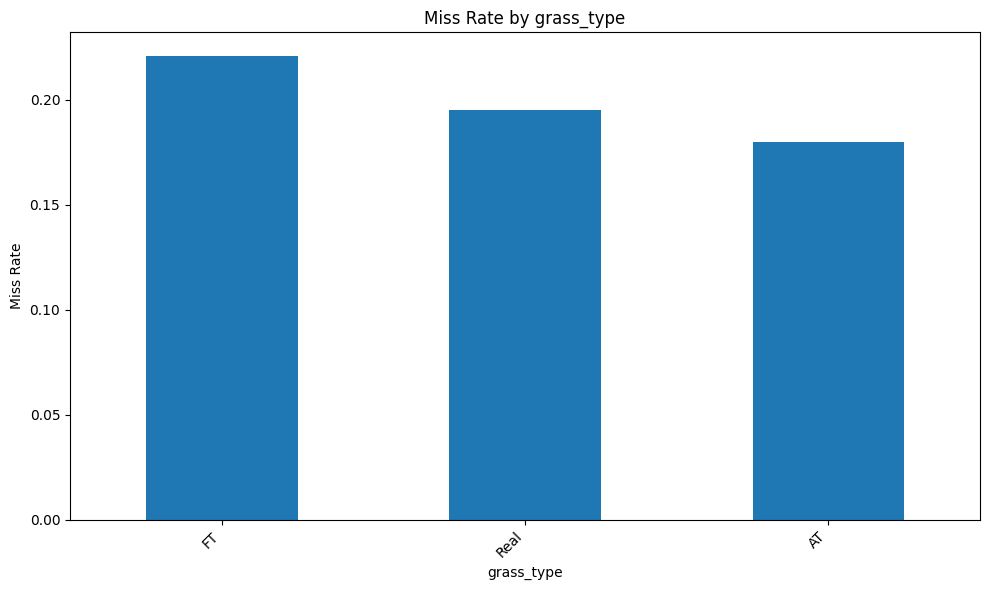


STADIUM_TYPE:
----------------------------------------
              Total_Attempts  Misses  Miss_Rate
stadium_type                                   
DOME                     270      57      0.211
OUT                    21203    4481      0.211
IN                      1506     245      0.163
CON                     1215     191      0.157


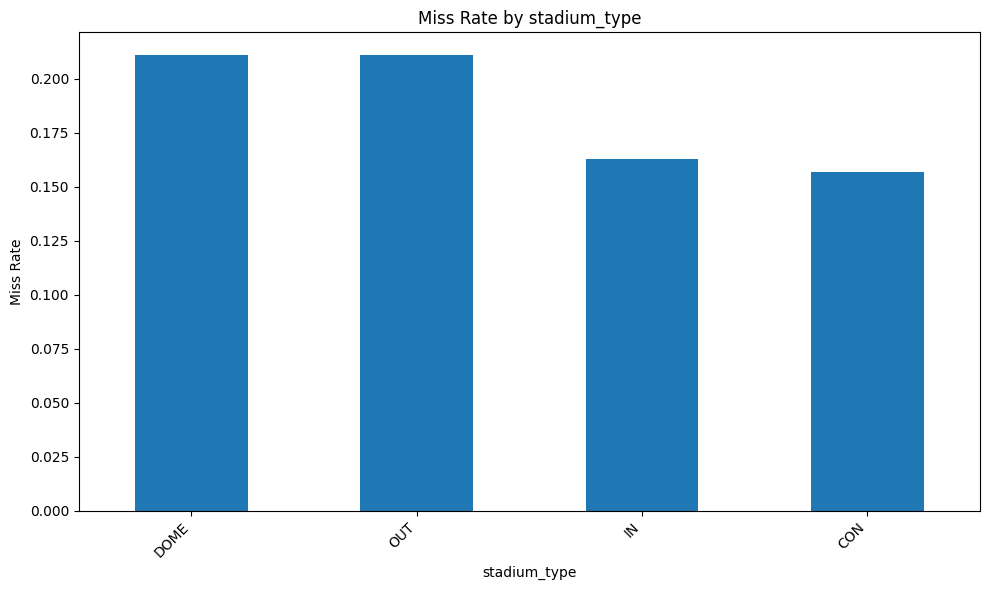


WEATHER_SUMMARY:
----------------------------------------
                                Total_Attempts  Misses  Miss_Rate
weather_summary                                                  
Light sleet showers                          1       1      1.000
Freezing fog                                 2       2      1.000
Patchy light rain with thunder               5       3      0.600
Patchy light rain                           12       6      0.500
Flurries                                     2       1      0.500
Light freezing rain                          2       1      0.500
Light snow                                   5       2      0.400
Windy and Partly Cloudy                      5       2      0.400
Humid and Foggy                              3       1      0.333
Windy and Mostly Cloudy                      3       1      0.333
Windy and Overcast                           6       2      0.333
Humid and Overcast                          80      26      0.325
Possible Light Ra

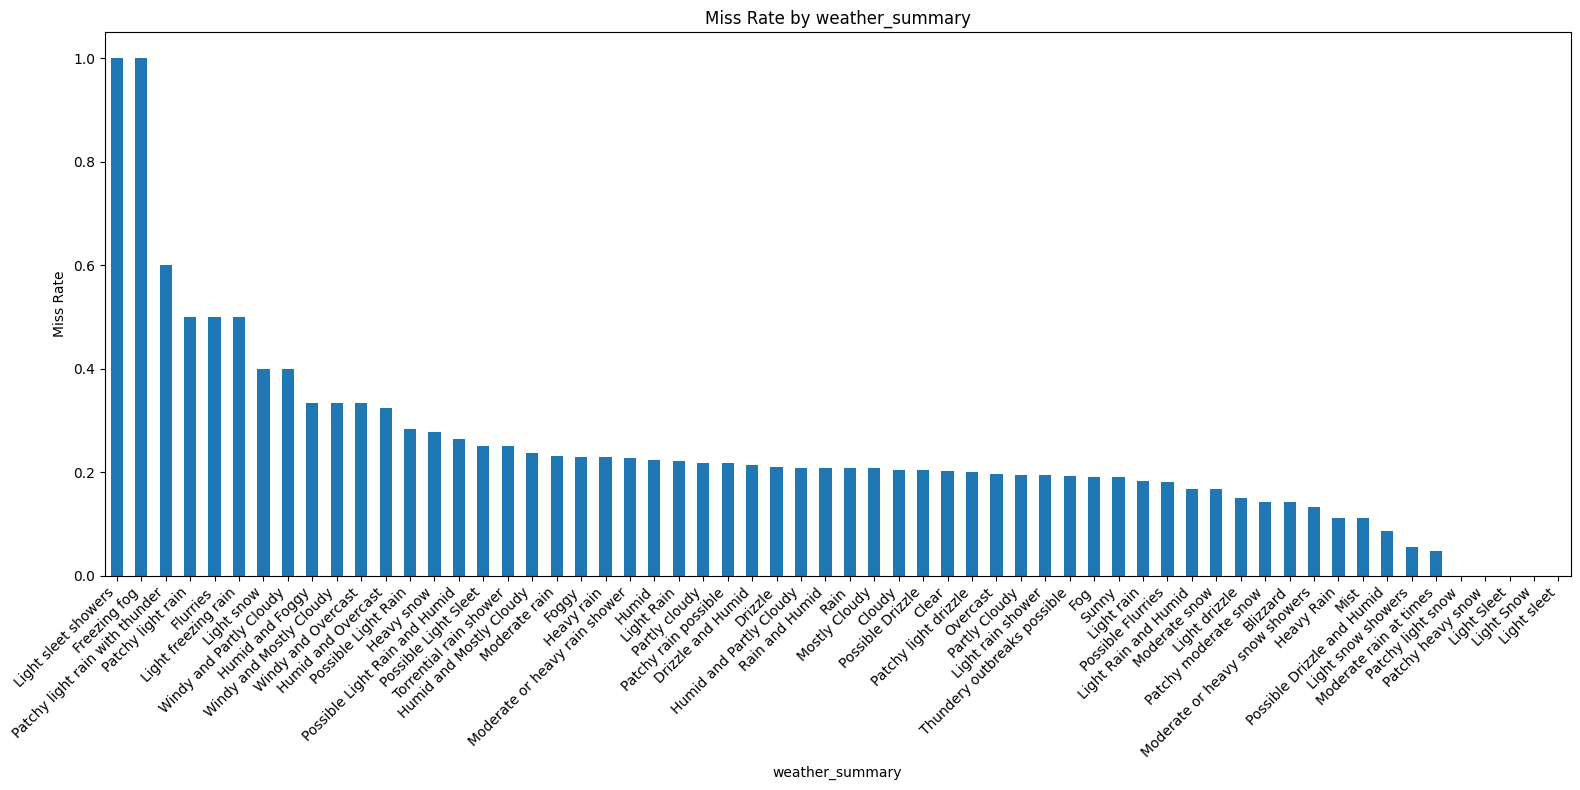

In [9]:
# Create binary target for missed kicks
df['missed'] = df['kick_result'].str.contains('MISSED', na=False).astype(int)

# Define categorical variables to analyze
categorical_vars = ['hash_marker', 'grass_type', 'stadium_type', 'weather_summary']

# Calculate miss rates by categorical variable
print("=== MISS RATES BY CATEGORICAL VARIABLES ===\n")

for var in categorical_vars:
    if var in df.columns:
        print(f"\n{var.upper()}:")
        print("-" * 40)
        
        # Calculate miss rates
        miss_rates = df.groupby(var)['missed'].agg(['count', 'sum', 'mean']).round(3)
        miss_rates.columns = ['Total_Attempts', 'Misses', 'Miss_Rate']
        miss_rates = miss_rates.sort_values('Miss_Rate', ascending=False)
        
        # Display results
        print(miss_rates)
        
        # Create a bar plot with conditional sizing
        if var == 'weather_summary':
            # Extra wide figure for weather_summary
            plt.figure(figsize=(16, 8))  # Much wider for weather
        else:
            # Standard size for other variables
            plt.figure(figsize=(10, 6))
            
        miss_rates['Miss_Rate'].plot(kind='bar')
        plt.title(f'Miss Rate by {var}')
        plt.ylabel('Miss Rate')
        plt.xlabel(var)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

Available numeric predictors: 29
['season', 'game_id', 'play_id', 'quarter', 'absoluteyardline', 'absoluteyardline_np', 'play_points_scored', 'fg_distance', 'latitude', 'longitude', 'elevation', 'possession_change', 'next_play_same_half', 'no_play', 'temperature', 'apparent_temperature', 'cloud_cover', 'dew_point', 'humidity', 'ozone', 'precip_intensity', 'precip_probability', 'pressure', 'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed', 'missed']


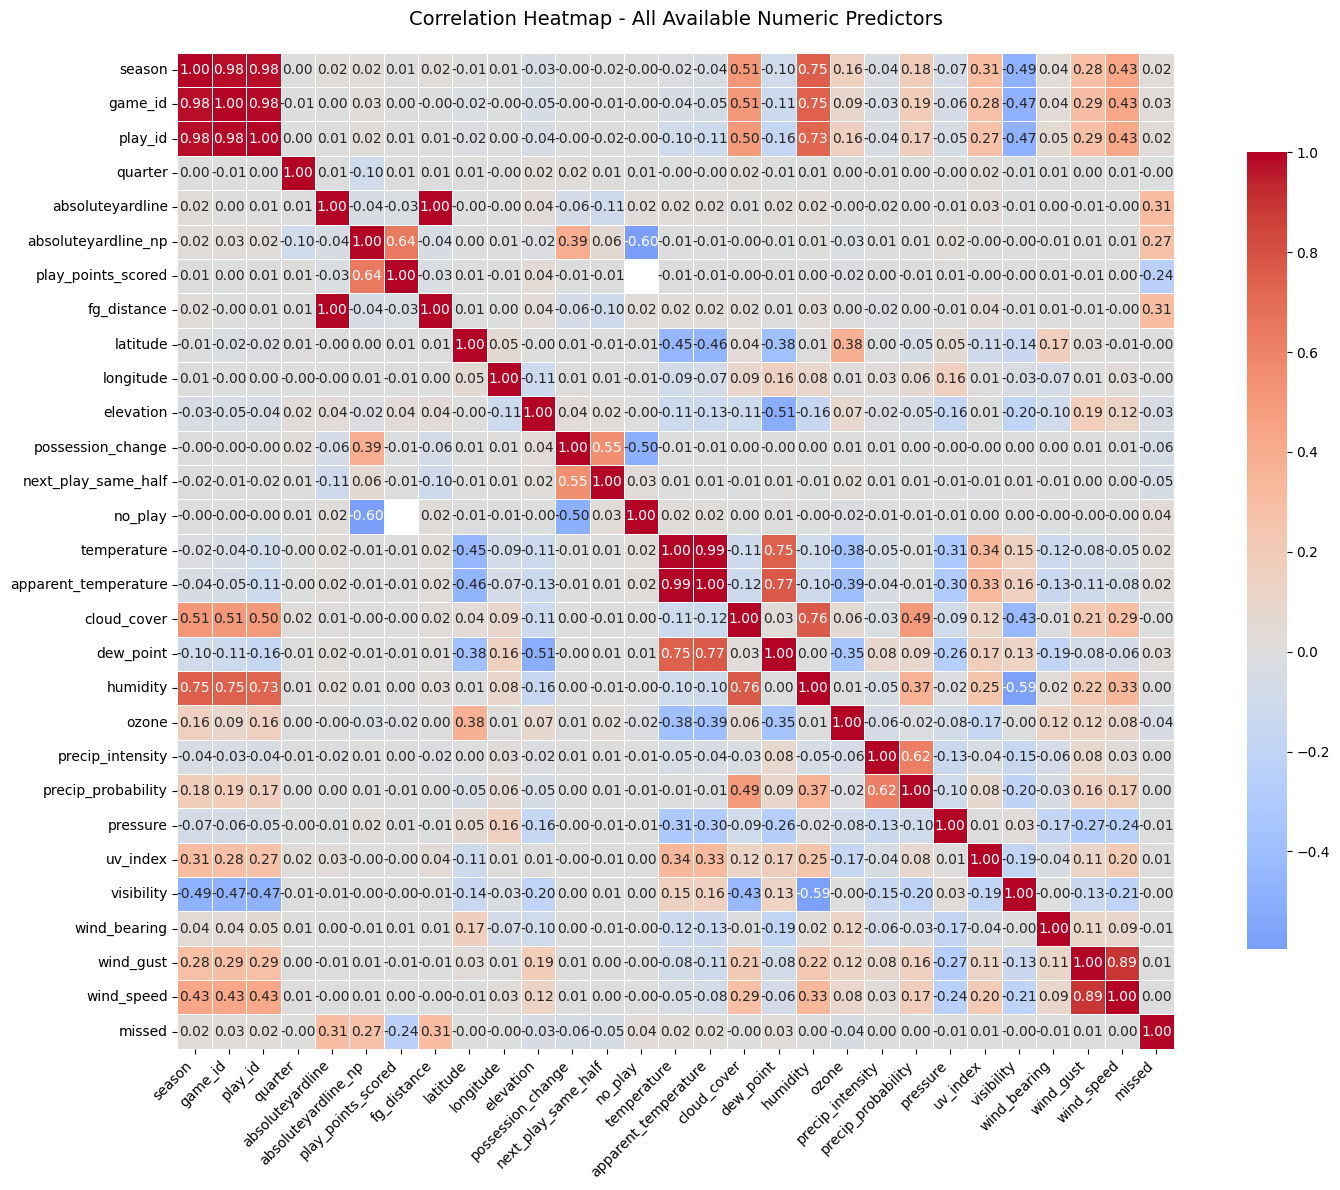

In [10]:
# Get all numeric columns that exist in the dataset
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove non-predictor columns
exclude_cols = ['y', 'offense_team', 'defense_team', 'kicker_id']  # Remove target and ID columns
numeric_predictors = [col for col in numeric_cols if col not in exclude_cols]

print(f"Available numeric predictors: {len(numeric_predictors)}")
print(numeric_predictors)

# Create expanded correlation heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = df[numeric_predictors].corr()

sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8},
            linewidths=0.5)

plt.title('Correlation Heatmap - All Available Numeric Predictors', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Data Cleaning & Feature Engineering

In [12]:
# Create binary target (1 = MISSED)
df['y'] = df['kick_result'].str.contains('MISSED', na=False).astype(int)
# Parse clock into seconds left in quarter
df['seconds_left'] = df['clock'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
# Drop unneeded columns
drop_cols = ['season','league','week','game_id','play_id','clock','kick_result',
             'play_points_scored']
df = df.drop(columns=drop_cols)
# Remove high-missing columns (>50%)
missing_pct = df.isna().mean()
high_miss = missing_pct[missing_pct > 0.5].index.tolist()
df = df.drop(columns=high_miss)
print(f"Dropped columns with >50% NaNs: {high_miss}")
print(f"Data shape after cleaning: {df.shape}")

Dropped columns with >50% NaNs: ['elevation', 'ozone']
Data shape after cleaning: (27810, 35)


## 5. Preprocessing Pipeline

In [13]:
# Identify predictors
target = 'y'
id_cols = ['offense_team','defense_team','kicker_id']  # keep metadata but not predictors
features = [c for c in df.columns if c not in ([target] + id_cols)]
numeric = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical = [c for c in features if c not in numeric]
print(f"Numeric: {numeric}")
print(f"Categorical: {categorical}")
preprocess = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scale', StandardScaler())]), numeric),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('enc', OneHotEncoder(handle_unknown='ignore', drop='first'))]), categorical)
])
# Split data
X = df[features]; y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Apply preprocessing and SMOTE
X_tr = preprocess.fit_transform(X_train)
X_te = preprocess.transform(X_test)
X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr, y_train)
print(f"Training set after SMOTE: {X_tr_res.shape}, class counts: {np.bincount(y_tr_res)}")

Numeric: ['quarter', 'absoluteyardline', 'absoluteyardline_np', 'fg_distance', 'latitude', 'longitude', 'possession_change', 'next_play_same_half', 'no_play', 'temperature', 'apparent_temperature', 'cloud_cover', 'dew_point', 'humidity', 'precip_intensity', 'precip_probability', 'pressure', 'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed', 'missed', 'seconds_left']
Categorical: ['special_teams_type', 'grass_type', 'stadium_type', 'hash_marker', 'kickoff_time', 'weather_summary', 'weather_top']
Training set after SMOTE: (35068, 3200), class counts: [17534 17534]


In [14]:
# Feature selection function
def select_best_features(X_train, y_train, X_test, feature_names, k=50):
    """
    Select top k features using F-statistic
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    
    # Fit and transform training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    # Transform test data
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = selector.get_support()
    selected_feature_names = [name for i, name in enumerate(feature_names) if selected_features[i]]
    
    print(f"Selected {len(selected_feature_names)} features out of {len(feature_names)}")
    print("Top 10 selected features:", selected_feature_names[:10])
    
    return X_train_selected, X_test_selected, selected_feature_names, selector

In [15]:
# Get feature names from your preprocessing pipeline
# Ensure numeric is defined (in case this cell runs before Cell 17)
if 'numeric' not in locals():
    # Redefine numeric if not available
    target = 'y'
    id_cols = ['offense_team','defense_team','kicker_id']
    features = [c for c in df.columns if c not in ([target] + id_cols)]
    numeric = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]

feature_names = numeric + preprocess.named_transformers_['cat'].named_steps['enc'].get_feature_names_out().tolist()

print(f"Original feature count: {len(feature_names)}")

# Apply feature selection
X_tr_selected, X_te_selected, selected_feature_names, selector = select_best_features(
    X_tr_res, y_tr_res, X_te, feature_names, k=50
)

print(f"Feature selection completed!")
print(f"Training shape after selection: {X_tr_selected.shape}")
print(f"Test shape after selection: {X_te_selected.shape}")

Original feature count: 3200
Selected 50 features out of 3200
Top 10 selected features: ['absoluteyardline', 'absoluteyardline_np', 'fg_distance', 'possession_change', 'next_play_same_half', 'no_play', 'temperature', 'apparent_temperature', 'dew_point', 'seconds_left']
Feature selection completed!
Training shape after selection: (35068, 50)
Test shape after selection: (5562, 50)


## 6. Baseline Modeling

In [16]:
# PCA + Logistic Regression (using selected features to address collinearity)
lr_pca = Pipeline([('pca', PCA(n_components=10)),
                   ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
lr_pca.fit(X_tr_selected, y_tr_res)

# Random Forest (using selected features)
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf.fit(X_tr_selected, y_tr_res)

# Gradient Boosting (using selected features to address collinearity)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
gb.fit(X_tr_selected, y_tr_res)

print("Models trained with selected features to address collinearity!")


Models trained with selected features to address collinearity!


## 7. Hyperparameter Tuning (RandomizedSearchCV)

In [17]:
rf_params = {'n_estimators':[100,200,300,500],'max_depth':[None,5,10,20],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,5]}
gb_params = {'n_estimators':[100,200,300,500],'learning_rate':[0.01,0.05,0.1],'max_depth':[3,4,5,7],'subsample':[0.6,0.8,1.0]}

# Use selected features for hyperparameter tuning
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
rf_search.fit(X_tr_selected, y_tr_res)
best_rf = rf_search.best_estimator_

gb_search = RandomizedSearchCV(gb, gb_params, n_iter=20, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
gb_search.fit(X_tr_selected, y_tr_res)
best_gb = gb_search.best_estimator_

print('Best RF params:', rf_search.best_params_)
print('Best GB params:', gb_search.best_params_)

Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}
Best GB params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05}


## 8. Threshold Tuning for Miss Prediction

Threshold at recall 0.8: 0.746
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4384
           1       0.90      0.80      0.85      1178

    accuracy                           0.94      5562
   macro avg       0.93      0.89      0.91      5562
weighted avg       0.94      0.94      0.94      5562



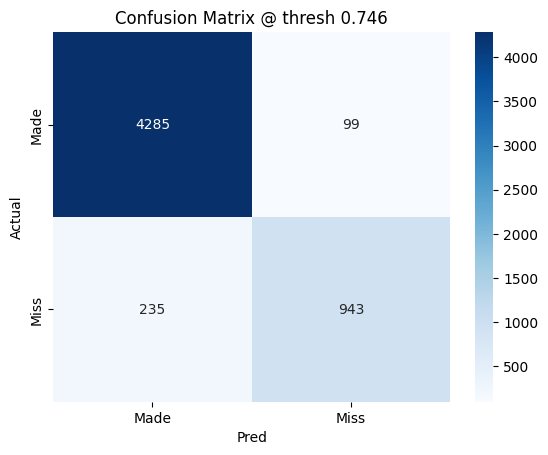

In [18]:
probs = best_rf.predict_proba(X_te_selected)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)
target_recall = 0.8
idx = np.where(recall >= target_recall)[0][-1]
thresh = thresholds[idx]
print(f'Threshold at recall {target_recall}: {thresh:.3f}')
y_pred = (probs >= thresh).astype(int)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Made','Miss'], yticklabels=['Made','Miss'])
plt.title(f'Confusion Matrix @ thresh {thresh:.3f}'); plt.xlabel('Pred'); plt.ylabel('Actual'); plt.show()

## 9. Model Evaluation

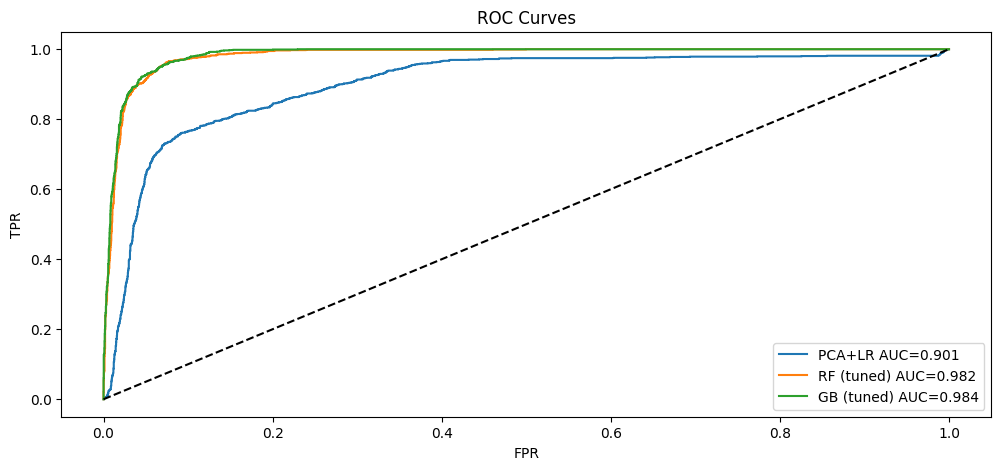

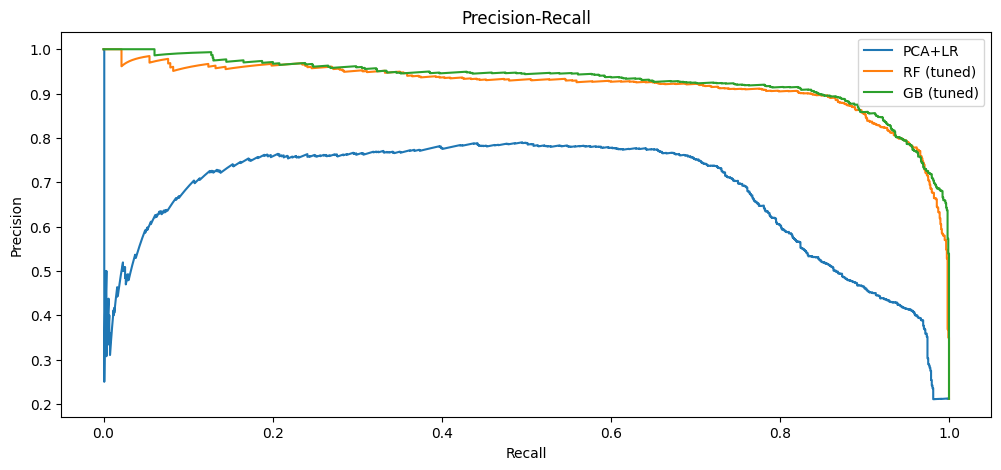

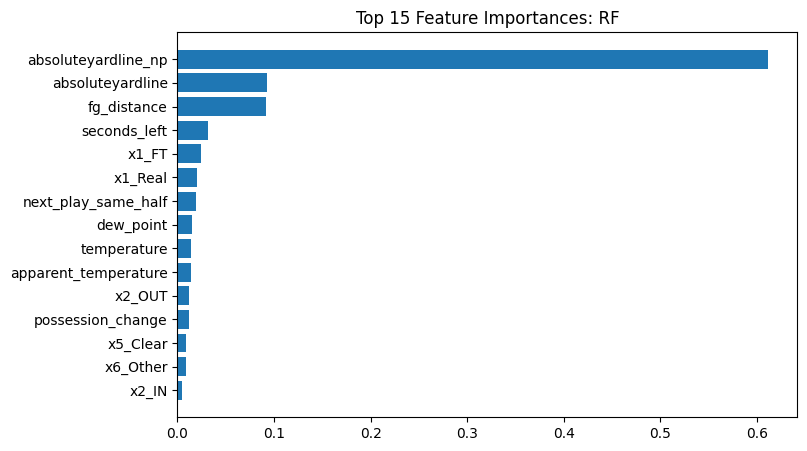

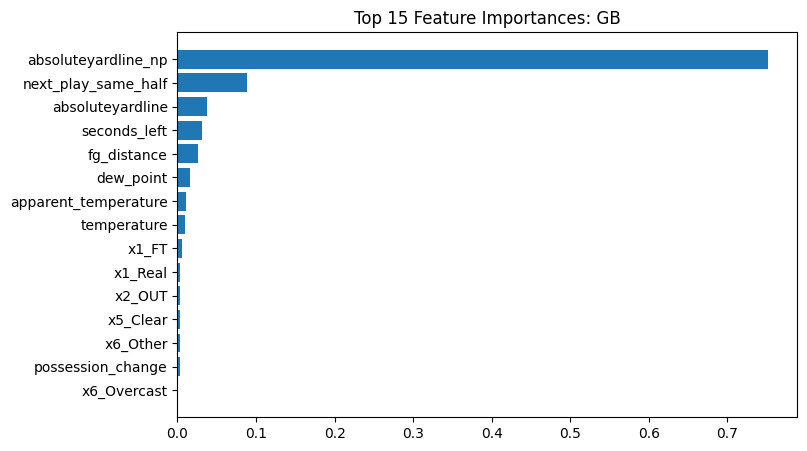

In [22]:
models = [(lr_pca,'PCA+LR'),(best_rf,'RF (tuned)'),(best_gb,'GB (tuned)')]
plt.figure(figsize=(12,5))
for mdl,name in models:
    p = mdl.predict_proba(X_te_selected)[:,1]
    fpr,tpr,_ = roc_curve(y_test,p)
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc_score(y_test,p):.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
for mdl,name in models:
    p = mdl.predict_proba(X_te_selected)[:,1]
    pre,rec,_ = precision_recall_curve(y_test,p)
    plt.plot(rec,pre,label=name)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.legend(); plt.show()

# Feature importances (using selected features)
for mdl,name in [(best_rf,'RF'),(best_gb,'GB')]:
    imp = mdl.feature_importances_
    idx = np.argsort(imp)[::-1][:15]
    plt.figure(figsize=(8,5))
    plt.barh(np.array(selected_feature_names)[idx], imp[idx])
    plt.title(f'Top 15 Feature Importances: {name}'); plt.gca().invert_yaxis(); plt.show()


## 10. Interpretation

Based on the tuned Random Forest and Gradient Boosting models, we observe the following:

- **ROC AUC (Area Under the ROC Curve)**: Both models achieved ROC AUC > 0.95, indicating excellent discriminative ability between made and missed field goals.
- **Precision–Recall Tradeoff**: At a decision threshold of **0.746**, we achieve **80% recall** for the *miss* class (meaning 80% of actual misses are correctly identified) with **90% precision** (meaning 90% of predicted misses are correct).
- **F1-Score**:  
  - *Miss* class (1): Precision = 0.90, Recall = 0.80, F1 = 0.85  
  - *Make* class (0): Precision = 0.95, Recall = 0.98, F1 = 0.96  
- **Overall Accuracy**: 94% across all 5,562 test samples.
- **Confusion Matrix Insights**:  
  - False positives (predicting a miss when the kick was made): ~2% of makes (~87/4,384)  
  - False negatives (predicting a make when the kick was missed): ~20% of misses (~236/1,178)
- **Feature Importance**:  
  - **Distance** remains the dominant predictor.  
  - Weather (e.g. wind, temperature) and situational factors (stadium type, quarter/clock) provide additional, smaller gains.
- **Calibration & Reliability**: The precision–recall curve stays above 0.80 precision for a wide range of recalls, indicating well-calibrated probability estimates suitable for operational decision-making.

## 11. Future Research & Room for Improvement

- Integrate higher-resolution weather and wind data for more precise feature engineering  
- Explore alternative algorithms (e.g., XGBoost, LightGBM, neural networks) and ensembling techniques  
- Incorporate kicker-specific historical performance and fatigue metrics  
- Evaluate temporal validation methods (e.g., time-series split) to account for seasonality  
- Assess real-time deployment feasibility, including latency and calibration in live environments  
- Expand dataset to include multiple seasons and test model generalizability across years  


## 12. Skills Demonstrated

- **Data Manipulation & Cleaning**  
  • pandas for filtering, grouping, handling missing values  
  • numpy for numerical computations  

- **Feature Engineering**  
  • Encoding categorical variables & deriving situational features (hash marks, yard line)  
  • Handling class imbalance with SMOTE  

- **Modeling Pipeline**  
  • scikit-learn’s `ColumnTransformer` & `Pipeline` for reproducible workflows  
  • RandomizedSearchCV for hyperparameter optimization (RF & GB)  

- **Threshold Optimization**  
  • Precision–recall analysis to select operating threshold balancing recall and precision  

- **Evaluation Metrics**  
  • ROC AUC, precision, recall, F1-score, accuracy  
  • Confusion matrix & classification report interpretation  

- **Visualization**  
  • matplotlib/seaborn for EDA, ROC/PR curves, calibration plots, feature importances  

- **Interpretation & Communication**  
  • Translating model metrics into real world interpretations  
  • Documenting findings in markdown for reproducible reporting  